In [1]:
from sklearn.datasets import make_classification
import pandas as pd

# Create a synthetic imbalanced dataset with 1000 samples, 10 features, and 5% positive class
X, y = make_classification(n_samples=1000, n_features=10, n_classes=2, 
                           weights=[0.95, 0.05], random_state=42)

# Convert to DataFrame for easy manipulation
data = pd.DataFrame(X, columns=[f'Feature_{i}' for i in range(1, 11)])
data['Target'] = y

data.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Target
0,0.964799,-0.066449,0.986768,-0.358079,0.997266,1.181890,-1.615679,-1.210161,-0.628077,1.227274,0
1,1.230350,-0.566395,1.169487,0.831617,-1.176962,1.820544,-1.788927,-0.984534,-1.091341,0.209470,0
2,0.969347,-0.432774,0.858089,0.793818,-0.268646,-1.836360,-1.216083,-0.246383,-1.066667,-0.297376,0
3,1.750412,2.023606,1.688159,0.006800,-1.607661,0.184741,-2.619427,-0.357445,-1.473127,-0.190039,0
4,-0.001184,-0.711303,0.208114,0.117124,1.536061,0.597538,-0.637329,-0.939156,0.684698,0.236224,0


In [2]:
# Show the class distribution
print(data['Target'].value_counts(normalize=True))

Target
0    0.947
1    0.053
Name: proportion, dtype: float64


In [3]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = data.drop(columns=['Target'])
y = data['Target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [4]:
print(X_train.shape); print(X_test.shape)

(700, 10)
(300, 10)


In [5]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Initialize the base estimator (Decision Tree)
base_estimator = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Initialize the Bagging Classifier
bagging_classifier = BaggingClassifier(base_estimator=base_estimator, n_estimators=100, random_state=42)

# Train the Bagging model
bagging_classifier.fit(X_train, y_train)

C:\Users\Vikash.Singh\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                        random_state=42),
                  n_estimators=100, random_state=42)

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Predictions on train and test sets
y_train_pred = bagging_classifier.predict(X_train)
y_test_pred = bagging_classifier.predict(X_test)

# Confusion Matrix, Classification Report, and AUC score for Training Set
print("Training Set:")
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))
train_auc = roc_auc_score(y_train, bagging_classifier.predict_proba(X_train)[:, 1])
print("AUC Score (Train):", train_auc)

# Confusion Matrix, Classification Report, and AUC score for Testing Set
print("\nTesting Set:")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))
test_auc = roc_auc_score(y_test, bagging_classifier.predict_proba(X_test)[:, 1])
print("AUC Score (Test):", test_auc)

Training Set:
[[663   0]
 [  0  37]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       663
           1       1.00      1.00      1.00        37

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700

AUC Score (Train): 1.0

Testing Set:
[[281   3]
 [ 10   6]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       284
           1       0.67      0.38      0.48        16

    accuracy                           0.96       300
   macro avg       0.82      0.68      0.73       300
weighted avg       0.95      0.96      0.95       300

AUC Score (Test): 0.884793133802817


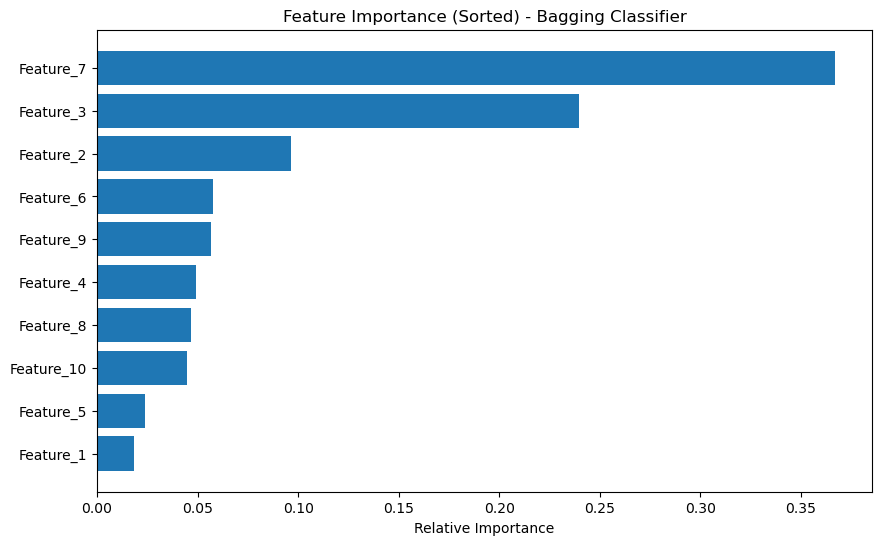

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances from the base estimator
importances = np.mean([tree.feature_importances_ for tree in bagging_classifier.estimators_], axis=0)
features = X.columns

# Sort features by importance in descending order
indices = np.argsort(importances)[::-1]

# Plot the feature importances in descending order
plt.figure(figsize=(10,6))
plt.title("Feature Importance (Sorted) - Bagging Classifier")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.gca().invert_yaxis()  # To have the most important feature at the top
plt.show()

In [8]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.75, 1.0],
    'bootstrap': [True, False],
    'base_estimator__max_depth': [None, 10, 20, 30],
    'base_estimator__min_samples_split': [2, 5, 10]
}

# Initialize RandomizedSearchCV
bagging_random = RandomizedSearchCV(estimator=bagging_classifier, param_distributions=param_dist, 
                                    n_iter=10, cv=3, random_state=42, n_jobs=-1)

# Fit the randomized search model
bagging_random.fit(X_train, y_train)

# Best parameters from the search
print("Best Parameters:", bagging_random.best_params_)

C:\Users\Vikash.Singh\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Best Parameters: {'n_estimators': 100, 'max_samples': 0.5, 'bootstrap': True, 'base_estimator__min_samples_split': 5, 'base_estimator__max_depth': 10}


In [9]:
# Initialize the Bagging Classifier with tuned hyperparameters
bagging_classifier_optimized = bagging_random.best_estimator_

# Train the optimized model
bagging_classifier_optimized.fit(X_train, y_train)

# Evaluate the optimized model
y_train_pred_optimized = bagging_classifier_optimized.predict(X_train)
y_test_pred_optimized = bagging_classifier_optimized.predict(X_test)

# Confusion Matrix and AUC for the optimized model - Training Set
print("Optimized Training Set:")
print(confusion_matrix(y_train, y_train_pred_optimized))
print(classification_report(y_train, y_train_pred_optimized))
train_auc_optimized = roc_auc_score(y_train, bagging_classifier_optimized.predict_proba(X_train)[:, 1])
print("AUC Score (Train - Optimized):", train_auc_optimized)

# Confusion Matrix and AUC for the optimized model - Testing Set
print("\nOptimized Testing Set:")
print(confusion_matrix(y_test, y_test_pred_optimized))
print(classification_report(y_test, y_test_pred_optimized))
test_auc_optimized = roc_auc_score(y_test, bagging_classifier_optimized.predict_proba(X_test)[:, 1])
print("AUC Score (Test - Optimized):", test_auc_optimized)


C:\Users\Vikash.Singh\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Optimized Training Set:
[[661   2]
 [ 13  24]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       663
           1       0.92      0.65      0.76        37

    accuracy                           0.98       700
   macro avg       0.95      0.82      0.88       700
weighted avg       0.98      0.98      0.98       700

AUC Score (Train - Optimized): 0.9976764094411154

Optimized Testing Set:
[[278   6]
 [ 11   5]]
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       284
           1       0.45      0.31      0.37        16

    accuracy                           0.94       300
   macro avg       0.71      0.65      0.67       300
weighted avg       0.93      0.94      0.94       300

AUC Score (Test - Optimized): 0.8735695422535212
